# Классификация при помощи ДПР

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE

# Описание набора данных

В этой лабораторной работе мы рассмотрим разные подходы к задаче классификации, в частности, деревья принятия решений, а также поговорим о том, как бороться с несбалансированностью датасета.

Изучаемый нами набор данных — это набор данных о принятых предложениях по кредитам в банке **Thera-Bank**. Основные клиенты банка пользуются банком для того, чтобы разместить в нем свои денежные средства, то есть являются вкладчиками. В то же время, большую прибыль банку приносят кредиторы — люди, берущие в банке кредит. Поэтому банк хочет сформировать для своих вкладчиков выгодные предложения по кредиту. Кампания, проведенная банком для вкладчиков в прошлом году, показала, что коэффициент конверсии составил более 9,6%. Это побудило отдел маркетинга разработать кампании с улучшенным целевым маркетингом, чтобы увеличить вероятность успеха при, естественно, минимальном бюджете. Департамент хотел бы разработать классификатор, который поможет им определить потенциальных клиентов, которые с большей вероятностью приобретут кредит. Это повысит вероятность успеха при одновременном снижении стоимости кампании.

Набор данных содержит как информацию о клиенте, так и информацию о его реакции на кампанию предыдущего года:

*   **ID**: ID клиента

*   **Age**: Возраст (полных лет)

*   **Experience**: Стаж

*   **Income**: Годовой доход (в тысячах)

*   **ZIP Code**: Индекс места проживания

*   **Family**: Количество членов семьи

*   **CCAvg**: Средние траты в месяц по кредитной карте (в тысячах)

*   **Education**: Уровень образования (1: бакалавр, 2: магистр, 3: что-то большее)

*   **Mortgage**: Стоимость ипотеки, если имеется (в тысячах)

*   **Securities Account**: Наличие счета в ценных бумагах

*   **CD Account**: Наличие сертификата на депозит

*   **Online**: Использует ли клиент интернет-банкинг

*   **CreditCard**: Использует ли клиент кредитную карту, выпущенную данным банком

*   **Personal Loan**: Принял ли клиент персональное предложение по кредиту (целевая переменная)

# Разведочный анализ данных

Считайте набор данных в датафрейм

In [ ]:
df = pd.read_csv('https://dc-edu.itmo.ru/assets/courseware/v1/0c61cf43490f9189f8ddb65a887dcc64/asset-v1:ITMO+bonus_track_methods+2023+type@asset+block/Bank_Personal_Loan_Modelling_train.csv')
df

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,409,60,36,89,91745,2,2.8,1,0,0,0,0,1,0
1,3738,44,19,30,91423,1,0.5,3,0,0,0,0,1,0
2,3890,26,0,19,93014,1,0.1,2,121,0,0,0,1,0
3,569,34,9,41,92101,2,0.1,1,161,0,0,0,1,1
4,1042,56,32,51,92780,4,1.5,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4588,37,11,59,94720,4,0.2,3,0,0,0,0,0,0
3996,2342,36,10,91,92028,1,1.5,3,289,0,0,0,1,0
3997,1586,57,31,131,90502,2,2.7,1,0,0,0,0,0,0
3998,3153,40,15,83,90275,1,1.0,3,0,0,0,0,0,0


При помощи метода <code>.describe()</code> изучите набор данных «с высоты птичьего полета».

In [ ]:
df.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000
mean,2497.682500,45.429500,20.196250,73.479750,93156.583750,2.381750,1.921805,1.881500,55.968250,0.096000,0.104000,0.061500,0.599000,0.29050
std,1449.723807,11.489235,11.500143,46.321345,2197.762636,1.149716,1.738974,0.842102,101.054887,0.294628,0.305299,0.240275,0.490162,0.45405
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1245.750000,35.000000,10.000000,38.000000,91941.750000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,2492.500000,45.000000,20.000000,63.000000,93407.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000
75%,3767.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,100.000000,0.000000,0.000000,0.000000,1.000000,1.00000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.000000,1.000000,1.00000


Набор данных содержит 14 переменных, 1 из которых является целевой.

1 номинальная переменная: **ID**

5 числовых переменных: **Age**, **Experience**, **Income**, **CCAvg**, **Mortgage**

3 категориальные переменных: **Family**, **Education**, **ZIP Code**

5 булевых переменных: **Personal Loan**, **Securities Account**, **CD Account**, **Online**, **CreditCard**

Пропущенных значений нет.

Experience содержит какие-то отрицательные значения

Удалите колонку ID, она нам не понадобится

In [ ]:
df = df.drop(columns=('ID'))

Имеет смысл попробовать отловить каике-либо зависимости или их отсутствие.

Постройте матрицу корреляций

In [ ]:
# строим матрицу корреляций признаков
corr_matrix = round(df.corr(), 3)
corr_matrix

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
Age,1.000,0.994,-0.047,-0.031,-0.034,-0.041,0.027,-0.003,-0.019,0.001,0.014,0.027,0.014
Experience,0.994,1.000,-0.038,-0.030,-0.040,-0.038,-0.001,-0.001,-0.018,0.000,0.016,0.027,0.016
Income,-0.047,-0.038,1.000,-0.016,-0.156,0.642,-0.192,0.197,0.497,0.005,0.180,0.013,0.009
ZIP Code,-0.031,-0.030,-0.016,1.000,0.006,-0.003,-0.020,0.003,-0.008,-0.001,0.008,0.008,0.001
Family,-0.034,-0.040,-0.156,0.006,1.000,-0.104,0.070,-0.024,0.063,0.012,0.019,0.012,0.010
CCAvg,-0.041,-0.038,0.642,-0.003,-0.104,1.000,-0.133,0.105,0.366,0.028,0.145,-0.004,0.004
Education,0.027,-0.001,-0.192,-0.020,0.070,-0.133,1.000,-0.028,0.135,-0.013,0.013,-0.018,-0.016
Mortgage,-0.003,-0.001,0.197,0.003,-0.024,0.105,-0.028,1.000,0.140,-0.002,0.093,0.008,-0.003
Personal Loan,-0.019,-0.018,0.497,-0.008,0.063,0.366,0.135,0.140,1.000,0.031,0.337,0.010,0.010
Securities Account,0.001,0.000,0.005,-0.001,0.012,0.028,-0.013,-0.002,0.031,1.000,0.325,0.015,-0.021


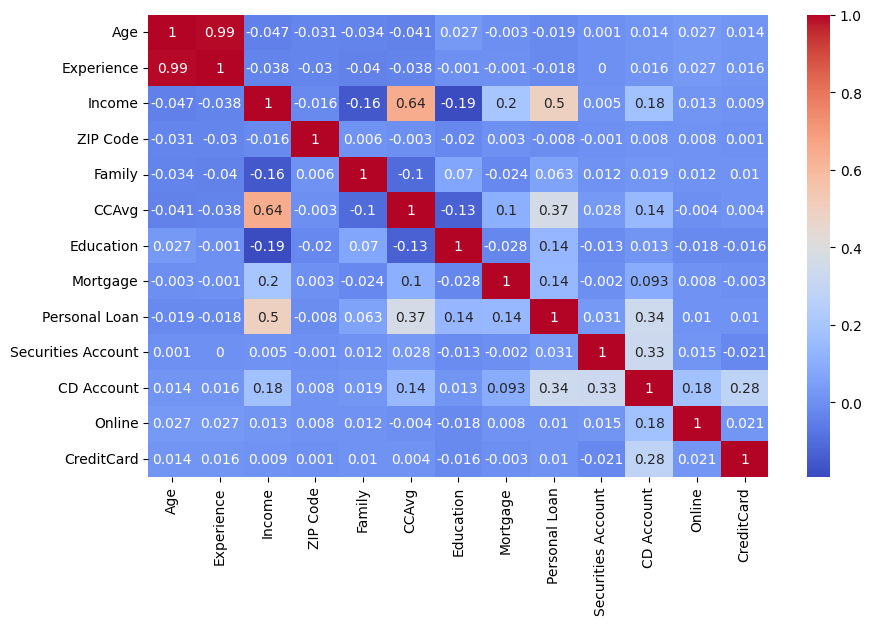

In [ ]:
# строим тепловую карту по матрице
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Определите две наиболее коррелированных переменных

In [ ]:
max_corr = 0
max_indicies = ()

for i in range(len(corr_matrix.columns)):
  for j in range(i + 1, len(corr_matrix.columns)):
    value = abs(corr_matrix.iloc[i, j])
    if value > max_corr:
      max_corr = value
      max_indicies = corr_matrix.index[i], corr_matrix.columns[j]

print(f'Две наиболее коррелированных переменных: {max_indicies[0]}, {max_indicies[1]}')

Две наиболее коррелированных переменных: Age, Experience


Определите признак, который меньше всего коррелирует (можно считать почти не коррелирует) с остальными признаками (в том числе с откликом). Удалите этот признак из рассмотрения.

Введите название удаленного признака.

In [ ]:
# определим признак, который меньше всего коррелирует с остальными
min_corr = 10
min_column = ''

for column in corr_matrix.columns:
  sum_corr = sum(abs(corr_matrix[column]))
  if sum_corr < min_corr:
    min_corr = sum_corr
    min_column = column

print(f'Признак, который меньше всего коррелирует с остальными: {min_column}')

Признак, который меньше всего коррелирует с остальными: ZIP Code


In [ ]:
# удалим этот признак из рассмотрения
df = df.drop(columns=min_column)

# Предварительная подготовка данных

## Модификация признаков

Стоит разобраться с полем <code>Experience</code>. Видно, что опыт коррелирует с возрастом. Однако, в поле <code>Experience</code> присутствуют отрицательные значения. Имеет смысл "сдвинуть" значения в этой колонке. Добавьте ко всем значениям колонки <code>Experience</code> одно число так, чтобы минимальное значение было равно $0$.

Вычислите выборочное среднее колонки <code>Experience</code> после преобразования.

In [ ]:
# добавим ко всем значениям колонки Experience модуль минимального значения
to_add = abs(df['Experience'].min())
df['Experience'] = df['Experience'] + to_add

In [ ]:
# вычислим выборочное среднее колонки Experience после преобразования
print('Выборочное среднее колонки Experience:', round(df['Experience'].mean(), 3))

Выборочное среднее колонки Experience: 23.196


Аналогично имеет смысл модфицировать поле <code>CCAvg</code>. Раз рассматривается годовой доход, то имеет смысл и значения трат рассматривать в рамках года.

Вычислите выборочное среднее колонки <code>CCAvg</code> после преобразования.

In [ ]:
# умножим колонку CCAvg на кол-во месяцев в году
df['CCAvg'] = df['CCAvg'] * 12

In [ ]:
# вычислим выборочное среднее колонки CCAvg после преобразования
print('Выборочное среднее колонки CCAvg:', round(df['CCAvg'].mean(), 3))

Выборочное среднее колонки CCAvg: 23.062


## Определение выбросов

Постройте ящики с усами для всех предикторов. Рекомендуем использовать <code>sns.boxplot()</code>. Определите признак по изображению boxplot из вашего варианта.

In [ ]:
# узнаем кол-во оставшихся предикторов
len(df.columns) - 1

11

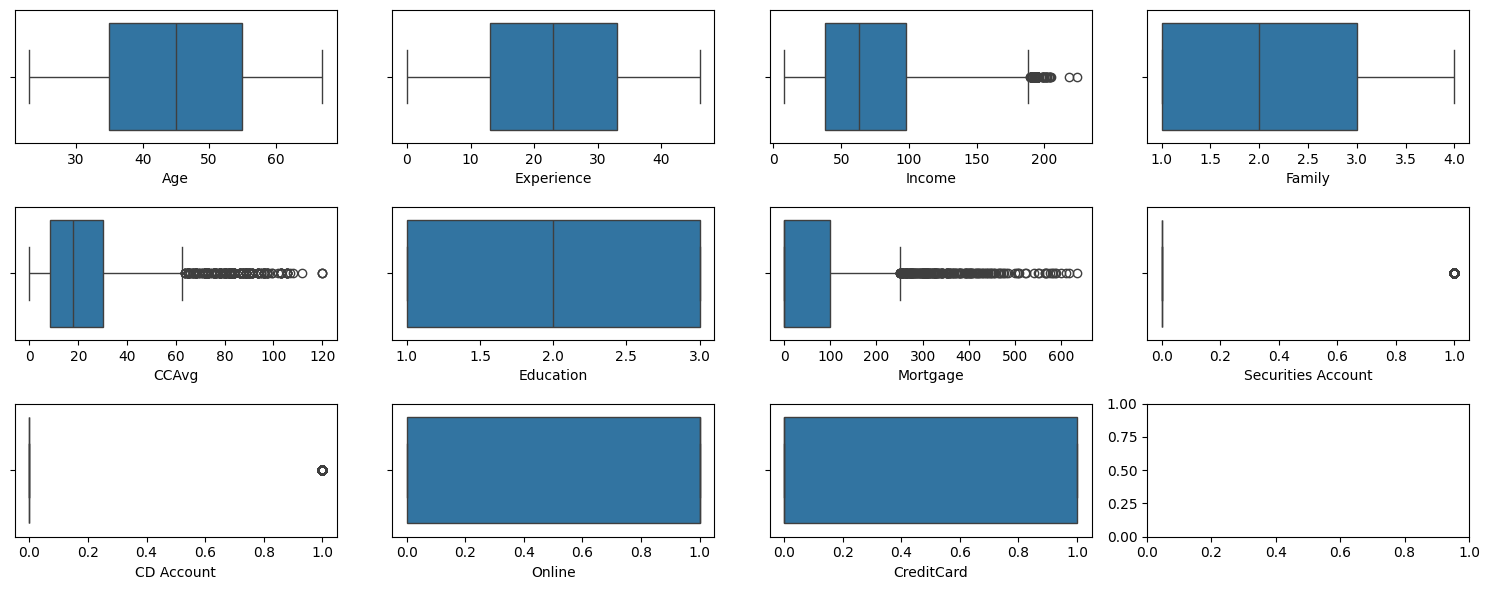

In [ ]:
# построим boxplot (ящики с усами) для предикторов
fig, axes = plt.subplots(3, 4, figsize=(15, 6))

for ax, column in zip(axes.flat, df.drop(columns=['Personal Loan']).columns):
  sns.boxplot(df, x=column, ax=ax)

plt.tight_layout()
plt.show()

Определите признак, содержащий наибольшее число выбросов. Введите название этого признака.


In [ ]:
def count_outliers(column):
  Q1 = column.quantile(0.25)
  Q3 = column.quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 3 * IQR
  upper_bound = Q3 + 3 * IQR
  return ((column < lower_bound) | (column > upper_bound)).sum()

df_cat_numeric = df[['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education', 'Mortgage']] # отберем числовые и категориальные признаки
outliers_count = df_cat_numeric.apply(count_outliers)
max_out_column = outliers_count.idxmax()

print(f'Признак, содержащий наибольшее число выбросов: {max_out_column}')

Признак, содержащий наибольшее число выбросов: Mortgage


Имеет смысл поработать с этим признаком, а для этого стоит руководствоваться следующими статистическими соображениями. Если вычесть из данных выборочное среднее, а после поделить на среднеквадратическое отклонение, то, пользуясь правилом 3-$\sigma$ для нормального распределения, можно выбросить слишком далекие от нуля хвосты. Постройте гистограмму распределения значений в рамках этого признака.

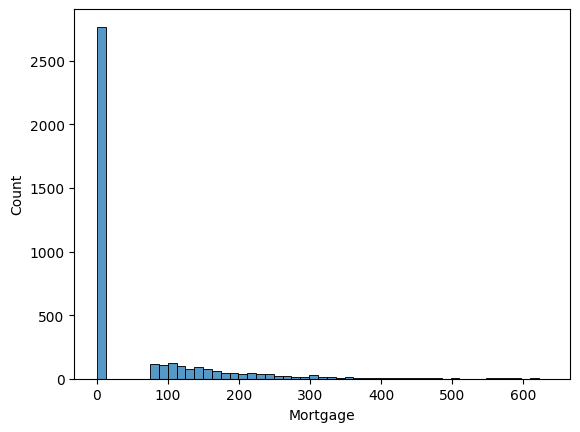

In [ ]:
# построим гистограмму распределения значений в рамках признака Mortgage
sns.histplot(df, x='Mortgage')
plt.show()

In [ ]:
# вычтем из данных выборочное среднее и поделим на среднеквадратическое отклонение
outliers = df['Mortgage']
outliers = outliers - outliers.mean()
outliers = outliers / outliers.std()

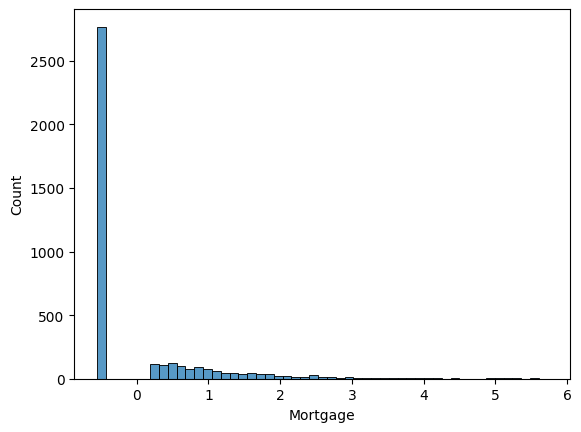

In [ ]:
# посмотрим на гистограмму распределения после преобразования
sns.histplot(outliers)
plt.show()

Очевидно в рамках этого признака есть небольшое количество значений, которые лежат далеко. Можно использовать <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html"><code>z-score</code></a> функцию из библиотеки <code>scipy</code>.

Вспомнив курс теории вероятностей, становится понятно, что около $99.7\%$ нормального распределения сождержатся в отрезке $[-3\sigma, 3\sigma]$. Определите число элементов, модуль <code>z-score</code> которых больше, чем $3$.

In [ ]:
zscores = zscore(outliers)
(abs(zscores) > 3).sum()

83

Итак, выбросов не очень множко, поэтому выбросите их из набора данных. Введите оставшееся в датасете число строк.

In [ ]:
# удалим выбросы из набора данных
outliers_index = zscores.index[abs(zscores) > 3]
df = df.drop(df.index[outliers_index])

In [ ]:
# вычислим оставшееся в датасете число строк
print(f'Оставшееся в датасете число строк: {len(df)}')

Оставшееся в датасете число строк: 3917


# Построение моделей

# Базовый алгоритм

При помощи <code>train_test_split</code> разобейте полученный набор данных на тренеровочную и тестовую выборки с параметрами, указанными в вашем варианте.

In [ ]:
# разобьем полученный набор данных на тренеровочную и тестовую выборки с параметрами test_size=0.2, random_state=41
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Personal Loan'), df['Personal Loan'], test_size=0.2, random_state=41, stratify=df['Personal Loan'])

print('Shapes', '    X', '       y')
print('train', X_train.shape, y_train.shape)
print('test ', X_test.shape, y_test.shape)

Shapes     X        y
train (3133, 11) (3133,)
test  (784, 11) (784,)


Обучите модель <code>DecisionTreeClassifier</code> с параметрами, указанными в вашем варианте на тренировочных данных, оцените на тестовых. Вычислите <code>f1_score</code> модели на тестовых данных.

In [ ]:
# обучим модель DecisionTreeClassifier с параметрами random_state=41, criterion='gini'
tree = DecisionTreeClassifier(random_state=41, criterion='gini').fit(X_train, y_train)

In [ ]:
# вычислим f1_score модели на тестовых данных
prediction = tree.predict(X_test)
print(f'f1_score: {round(f1_score(y_test, prediction), 3)}')

f1_score: 0.87


In [ ]:
# обучим модель DecisionTreeClassifier с параметрами random_state=41, criterion='entropy'
tree1 = DecisionTreeClassifier(random_state=41, criterion='entropy').fit(X_train, y_train)

In [ ]:
# вычислим f1_score модели на тестовых данных
prediction1 = tree1.predict(X_test)
print(f'f1_score: {round(f1_score(y_test, prediction1), 3)}')

f1_score: 0.887


## Учет дисбаланса соотношения классов

А теперь, если вспомнить, что выборка несбалансирована, то можно указать дополнительный параметр <code>class_weight</code>. Обучите модель <code>DecisionTreeClassifier</code> с параметрами, указанными в вашем варианте на тренировочных данных, оцените на тестовых. Вычислите <code>f1_score</code> модели на тестовых данных.

In [ ]:
# обучим модель DecisionTreeClassifier с параметрами random_state=41, criterion='gini', class_weight='balanced'
tree2 = DecisionTreeClassifier(random_state=41, criterion='gini', class_weight='balanced').fit(X_train, y_train)

In [ ]:
# вычислим f1_score модели на тестовых данных
prediction2 = tree2.predict(X_test)
print(f'f1_score: {round(f1_score(y_test, prediction2), 3)}')

f1_score: 0.862


In [ ]:
# обучим модель DecisionTreeClassifier с параметрами random_state=41, criterion='entropy', class_weight='balanced'
tree3 = DecisionTreeClassifier(random_state=41, criterion='entropy', class_weight='balanced').fit(X_train, y_train)

In [ ]:
# вычислим f1_score модели на тестовых данных
prediction3 = tree3.predict(X_test)
print(f'f1_score: {round(f1_score(y_test, prediction3), 3)}')

f1_score: 0.84


## Upsampling обучающей выборки

Помимо очевидного присвоения весов несбалансированным классам, можно воспользоваться алгоритмом <code>SMOTE</code>. Ему на вход подаются экземпляры всех классов с их метками, а он в свою очередь пытается на их основе экстраполировать само распределение данных этого класса. После этого он сэмплирует новые объекты классов так, пока количество строк каждого класса не станет везде одинаковым.

Получается, что в таком случае будет получена сбалансированная выборка, и пропадет нужда как-то ухищряться с весами и прочим.

Определите долю элементов класса $0$ тренировочного набора данных.

In [ ]:
print(f'Доля элементов класса 0 тренировочного набора данных: {round(y_train.value_counts(normalize=True)[0], 3)}')

Доля элементов класса 0 тренировочного набора данных: 0.911


Используя класс <a href="https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html"><code>SMOTE</code></a> из модуля <code>imblearn.over_sampling</code> сбалансируйте обучающую выборку с параметрами, указанными в вашем варианте.

In [ ]:
# сбалансируем обучающую выборку с параметрами random_state=41
sm = SMOTE(random_state=41)
X_train, y_train = sm.fit_resample(X_train, y_train)

Убедитесь, что теперь в выборке содержится одинаковое число представителей обоих классов. Введите количество объектов класса $1$.

In [ ]:
print(f'Кол-во элементов класса 1 тренировочного набора данных: {y_train.value_counts()[1]}')

Кол-во элементов класса 1 тренировочного набора данных: 2855


Снова обучите модель <code>DecisionTreeClassifier</code> с параметрами, указанными в вашем варианте на тренировочных данных, оцените на тестовых. Вычислите <code>f1_score</code> модели на тестовых данных.

In [ ]:
# обучим модель DecisionTreeClassifier с параметрами random_state=41, criterion='gini'
tree4 = DecisionTreeClassifier(random_state=41, criterion='gini').fit(X_train, y_train)

In [ ]:
# вычислим f1_score модели на тестовых данных
prediction4 = tree4.predict(X_test)
print(f'f1_score: {round(f1_score(y_test, prediction4), 3)}')

f1_score: 0.859


In [ ]:
# обучим модель DecisionTreeClassifier с параметрами random_state=41, criterion='entropy'
tree5 = DecisionTreeClassifier(random_state=41, criterion='entropy').fit(X_train, y_train)

In [ ]:
# вычислим f1_score модели на тестовых данных
prediction5 = tree5.predict(X_test)
print(f'f1_score: {round(f1_score(y_test, prediction5), 3)}')

f1_score: 0.831
